In [23]:
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from keras.layers import *
from keras.models import Sequential

env: CUDA_VISIBLE_DEVICES=2


In [24]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from IPython.display import HTML

In [25]:
import numpy as np
data = np.load('GAN_sandbox/ecalNT.npz')

In [26]:
data.files

['TotalEnergySci',
 'TotalEnergyAbsorb',
 'ParticlePoint',
 'EnergyDeposit',
 'ParticlePDG',
 'ParticleMomentum']

In [27]:
IMG_SHAPE = data['EnergyDeposit'][9].shape
data_img = data['EnergyDeposit']
data_img = np.log(np.where (data_img>0, data_img, 1e-12))
print (data_img.shape)

(10000, 30, 30)


In [28]:
def normalize_response(v):
    mean_ = np.mean(v,axis=(1,2))
    std_ = np.std(v,axis=(1,2))
    return ((v - np.mean(v,axis=(1,2))[:,None,None]) / (np.std(v,axis=(1,2))[:,None,None]+1e-9), mean_,std_)

def normalize_response_mean(v):
    mean_ = np.mean(v,axis=(0,1,2))
    std_ = np.std(v,axis=(0,1,2))
    return ((v - mean_) / std_+1e-9, mean_,std_)

def denormalize_response(v, mean_, std_):
    answ = []
    for ind, elem in enumerate(v):
        #print (elem)
        answ.append(elem*std_[ind] + mean_[ind])
    return np.array(answ)

def denormalize_response_mean(v, mean_, std_):
    answ = []
    for ind, elem in enumerate(v):
        #print (np.sum(elem))
        answ.append(elem*std_ + mean_)
    return np.array(answ)

In [29]:
a = normalize_response(data_img)
b = denormalize_response(a[0], a[1], a[2])
a = normalize_response_mean(data_img)
print (np.mean(a[1]), np.mean(a[2]))
b_mean = denormalize_response_mean(a[0], a[1], a[2])

-24.7226418485 8.60606335952


In [30]:
np.sum(a[0], axis=(1,2))

array([ -39.53544068,   25.67050341,   25.70726398, ...,  -45.78070308,
        120.23175905,  -45.90925669])

In [31]:
np.sum(b, axis=(1,2))

array([-22590.62217883, -22029.45569256, -22029.13932876, ...,
       -22644.36930276, -21215.65553523, -22645.47564324])

In [32]:
np.sum(b_mean, axis=(1,2))

array([-22590.62217108, -22029.45568482, -22029.13932102, ...,
       -22644.36929502, -21215.65552748, -22645.4756355 ])

In [33]:
b_mean = denormalize_response_mean(a[0], np.mean(a[1]), np.mean(a[2]))

**correctness of normalizing**

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


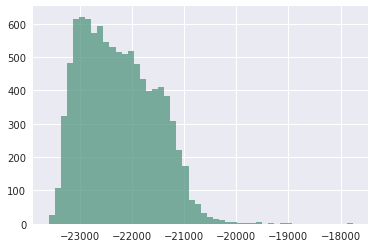

In [34]:
plt.hist(np.sum(data_img, axis=(1,2)), bins = 50, alpha = 0.5)
#plt.hist(np.sum(b, axis=(1,2)), bins = 50, alpha = 0.5)
plt.hist(np.sum(b_mean, axis=(1,2)), bins = 50, alpha = 0.5)
plt.show()

## explore data ##

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


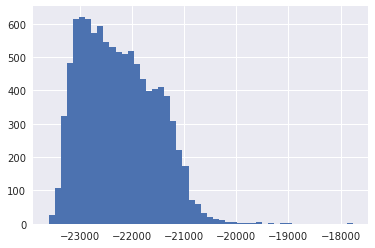

NameError: name 'flat_data' is not defined

In [35]:
plt.hist(np.sum(data_img, axis=(1,2)), bins = 50)
plt.show()
plt.hist(flat_data, bins = 250)
plt.ylim([0, 250000])
#plt.xlim([-0, 0.1])
plt.show()

REAL


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


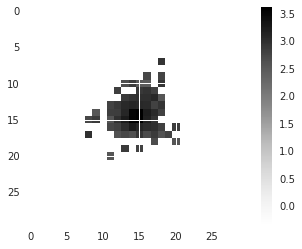

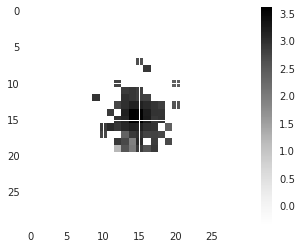

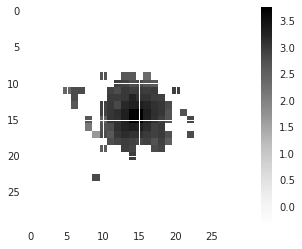

In [36]:
idxs = np.random.choice(np.arange(100), size=3)
print ('REAL')
for ind, elem in enumerate(a[0][idxs]):
    #print (np.log(elem+1))
    plt.imshow(elem)
    plt.colorbar()
    plt.show()

In [37]:
np.prod(np.array(IMG_SHAPE))

900

In [38]:
[None,]+list(IMG_SHAPE)

[None, 30, 30]

In [39]:
CODE_SIZE = 32

tf.reset_default_graph()
gen = Sequential()
gen.add(InputLayer([CODE_SIZE]))
gen.add(Dense(16, activation='elu'))
gen.add(Dense(64, activation='elu'))
print (gen.output_shape[1:])
gen.add(Dense(64, activation='elu'))
gen.add(Dense(np.prod(np.array(IMG_SHAPE))))
print (gen.output_shape[1:])
gen.add(Reshape((IMG_SHAPE), input_shape=(np.prod(np.array(IMG_SHAPE)),)))
disc = Sequential()
disc.add(InputLayer(list(IMG_SHAPE)))
disc.add(Flatten())
print (disc.output_shape[1:])
disc.add(Dense(32, activation='elu'))
print (disc.output_shape[1:])
#disc.add(Dense(64, activation='elu'))
print (disc.output_shape[1:])
disc.add(Dense(2))
print (disc.output_shape[1:])

batch_size = tf.placeholder_with_default(128, [])

z = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

weight_0 = disc.layers[0].output
weight_1 = disc.layers[1].get_weights()

gen_data = gen(z)
print (real_data.get_shape)
print (gen_data.get_shape)
logits_on_real_data = disc(real_data)
logits_on_gen_data = disc(gen_data)


IS_REAL = 1
IS_FAKE = 0

disc_loss = - 0.5 * tf.reduce_mean( tf.nn.log_softmax(logits_on_real_data)[:, IS_REAL] 
                                   +tf.nn.log_softmax(logits_on_gen_data)[:, IS_FAKE])

gen_loss = - tf.reduce_mean(tf.nn.log_softmax(logits_on_gen_data)[:, IS_REAL])


train_gen = tf.train.GradientDescentOptimizer(1e-2).minimize(gen_loss, var_list = gen.trainable_weights)
train_disc = tf.train.GradientDescentOptimizer(1e-3).minimize(disc_loss, var_list = disc.trainable_weights)

(64,)
(900,)
(900,)
(32,)
(32,)
(2,)
<bound method Tensor.get_shape of <tf.Tensor 'Placeholder_1:0' shape=(?, 30, 30) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'sequential_1/reshape_1/Reshape:0' shape=(?, 30, 30) dtype=float32>>


In [40]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [41]:
def sample_noise_batch(bsize):
    return np.random.normal(loc=2.0, scale=0.5,size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(a[0].shape[0]), size=bsize)
    return a[0][idxs]

In [42]:
print (np.max(sample_noise_batch(1000)), np.min(sample_noise_batch(1000)))
print (np.max(sample_data_batch(1000)), np.min(sample_data_batch(1000)))

3.97221 -0.101192
3.84289273178 -0.337945369133


In [43]:

feed_dict = {
        real_data:sample_data_batch(100),
        z:sample_noise_batch(100)
    }
#sess.run(train_disc, feed_dict)
#sess.run(train_gen, feed_dict)   

i 26000
891.628
(2, 2)
2.77013
-0.585172
[[ 1.06329083  1.06774771]
 [-0.36504281 -0.36890048]]


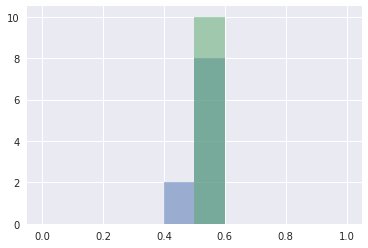

KeyboardInterrupt: 

In [44]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

r_ = []
g_ = []
for i in range(100000):
    feed_dict = {
        real_data:sample_data_batch(100),
        z:sample_noise_batch(100)
    }
    for _ in range(3):
        sess.run(train_disc, feed_dict)
    sess.run(train_gen, feed_dict)
    
    if i % 1000 == 0:
        print ('i', i)
        clear_output(True)
        print ('i', i)
        print(np.sum((sess.run(real_data, feed_dict))))
        print (sess.run(logits_on_real_data[:2], feed_dict).shape)
        print (np.max(sess.run(logits_on_real_data, feed_dict)))
        print (np.min(sess.run(logits_on_real_data, feed_dict)))
        print(sess.run(logits_on_real_data, feed_dict)[:2])
        #print(len((sess.run(weight_0, feed_dict))[:2]))
        plt.hist(sess.run(tf.nn.softmax(logits_on_real_data)[:, IS_REAL], feed_dict), range=[0, 1], alpha=0.5, normed=True)
        plt.hist(sess.run(tf.nn.softmax(logits_on_gen_data)[:, IS_REAL], feed_dict), range=[0, 1], alpha=0.5, normed=True)
        plt.show()
        #plt.hist(sess.run(tf.nn.softmax(logits_on_real_data)[:, IS_REAL], feed_dict))
                 #range=[0, 1], alpha=0.5)
        #plt.hist(sess.run(tf.nn.softmax(logits_on_gen_data)[:, IS_REAL], feed_dict))
                # range=[0, 1], alpha=0.5)
        real_ = sess.run(real_data, feed_dict)
        gen_ =  sess.run(gen_data, feed_dict)
        r_.append(real_)
        g_.append(gen_)
        plt.show()

In [46]:
print (np.array(r_).shape, np.array(g_).shape)
nr_ = np.array(r_).reshape(27*100, 30, 30)
ng_ = np.array(g_).reshape(27*100, 30, 30)

(27, 100, 30, 30) (27, 100, 30, 30)


In [47]:
r_[0]

array([[[-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        ..., 
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537]],

       [[-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        [-0.33794537, -0.33794537, -0.33794537, ..., -0.33794537,
         -0.33794537, -0.33794537],
        ..., 
        [-0.33794537, -0.33794537, -0.33794537, ...,

REAL


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


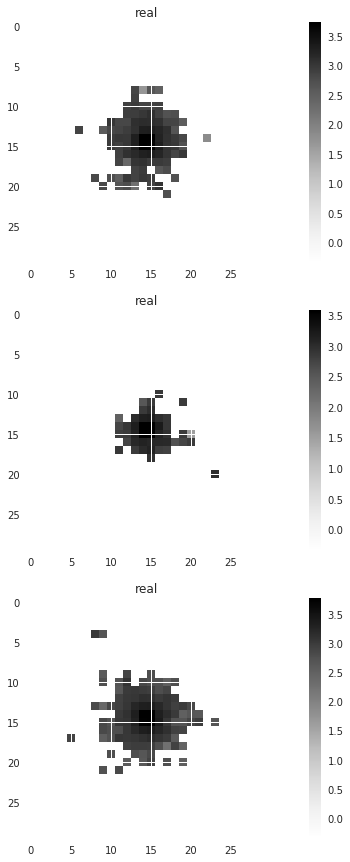

GEN


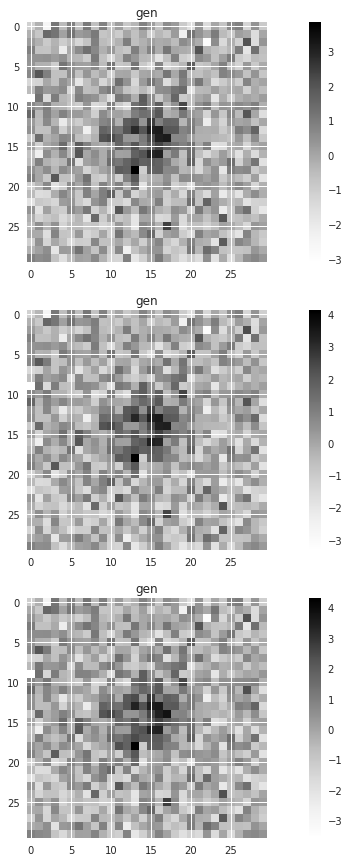

In [48]:
idxs = np.random.choice(np.arange(100), size=3)
print ('REAL')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for ind, elem in enumerate(real_[idxs]):
    plt.subplot(3, 1, ind+1)
    plt.imshow(elem)
    plt.title('real')
    plt.colorbar()
plt.savefig('sq_real.png')
plt.show()
print ('GEN')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for ind, elem in enumerate(gen_[idxs]):
    plt.subplot(3, 1, ind+1)
    plt.imshow(elem)
    plt.title('gen')
    plt.colorbar()
plt.savefig('sq_gen.png')
plt.show()

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


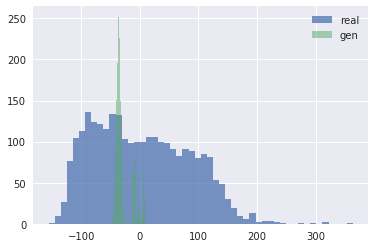

In [49]:
plt.hist(np.sum(nr_, axis=(1,2)), bins=50, alpha = 0.75, label = 'real')
plt.hist(np.sum(ng_, axis=(1,2)), bins=50, alpha = 0.5, label = 'gen')
plt.legend()
plt.savefig('my_gan_energy.png')
plt.show()